# Vibe Coding a modern diffusion pipeline (NVIDIA EDM, SR3, Toyota SR)

* Nvidia - Elucidating the Design Space of Diffusion-Based Generative Models - https://arxiv.org/abs/2206.00364
* Toyota - Efficient Burst Super-Resolution with One-step Diffusion - https://arxiv.org/abs/2507.13607
* Google SR3 - Image Super-Resolution via Iterative Refinement - https://arxiv.org/abs/2104.07636


## 1. Install and Import Required Libraries

We will use PyTorch, torchvision, numpy, matplotlib, and tqdm. If running locally, ensure these packages are installed.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import base64
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import transforms
from datetime import datetime
from io import BytesIO
from PIL import Image, ImageOps
from tqdm import tqdm
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import io
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HR = 256
LR = 64
max_training_time = 60*5
display_interval = 30

# https://www.kaggle.com/datasets/chetankv/dogs-cats-images
# https://www.kaggle.com/datasets/nerfviking/fantasyscifi-full-body-character-concepts
# https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset
experiments = {
    "fantasy": ("./data/fantasy", "checkpoints/UNet128_2025-09-14_17-47-44_fantasy.pth", "checkpoints/UNetSR3_2025-09-14_17-32-01_fantasy.pth"),
    "cats_and_dogs": ("./data/cats_and_dogs/dataset/training_set", "checkpoints/UNet128_2025-09-08_17-57-30_cats_and_dogs.pth",None),
    "pokemon": ("./data/pokemon_archive","UNet128_2025-09-12_11-03-12_pokemon.pth",None),
    "dragon": ("utils/dataset_fetcher/datasets/", 'checkpoints/UNet128_2025-09-17_01-57-51_dragon.pth',None),
    "yugioh": ("data/yugioh/YuGiOhImages",None,None),
    "mnist": (None,None,None),
}

experiment_name = "fantasy"
src_data, diffusion_weights,checkpoint_weights = experiments[experiment_name]

## 3. Define a Vision Mmodel for a Diffusion Model Architecture

* **Sinusoidal Timestep Embedding**
  * → Encodes diffusion step (time) as a multi-frequency vector. Lets the model “know” how much noise is present and what stage of denoising it’s in.
* **Optional Self-Attention at Lower Resolutions (e.g. 16×16)**
  * → Lets distant parts of the image “talk to each other,” useful for global structure (symmetry, object coherence). Limited to low-res maps to save compute.
* **SiLU/Swish activations**
  * → Smooth nonlinearities, empirically better than ReLU in diffusion U-Nets.

In [3]:
from elucidated_diffusion.models.chatgpt_diffusion_unet import UNet128

In [4]:
if show_model_info := False:
    model = UNet128(use_attention=True).to(device)
    print(model)

    # Total parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")

    # Trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params}")

    from torchview import draw_graph
    model = UNet128(use_attention=True).to(device)
    x,t = torch.rand(12, 3, 64, 64), torch.rand(12)
    #print(x,t)
    model_graph = draw_graph(model, input_data=(x,t), device='meta')
    model_graph.visual_graph

    type(model_graph.visual_graph)
    model_graph.visual_graph.render(filename='doc/diffusion_model_graph', format='svg', cleanup=True)
    model_graph.visual_graph.render(filename='doc/diffusion_model_graph', format='pdf', cleanup=True)
    svg_data = model_graph.visual_graph.pipe(format='svg')
    #ipd.display(ipd.SVG(svg_data))
    del(model)



## 4. Load and Preprocess Dataset

We will use any image directory for demonstration. The images will be normalized to [-1, 1] as required by most diffusion models.

In [5]:
# Scale to [-1, 1] (diffusion models usually expect this)
def scale_to_minus_one_to_one(x):
    return x * 2. - 1.

from torch.utils.data import Dataset
import torch.nn.functional as F

class LRHRDataset(Dataset):
    """
    Wraps an existing dataset that returns [3,H,H] tensors in [-1,1],
    and produces:
      - hr: [3, HR, HR]
      - lr: [3, LR, LR]
      #- cond_lr_up [3, HR, HR] (LR downsampled to LR_SIZE then upsampled)
    """
    def __init__(self, hr_dataset, lr_size=LR, hr_size=HR):
        super().__init__()
        self.hr_dataset = hr_dataset
        self.lr_size = lr_size
        self.hr_size = hr_size

    def __len__(self):
        return len(self.hr_dataset)

    def __getitem__(self, idx):
        hr_img, _ = self.hr_dataset[idx]  # [3,HR,HR]
        # Ensure it's [3,HR,HR]
        hr_img = F.interpolate(hr_img.unsqueeze(0), size=(self.hr_size, self.hr_size),
                               mode='bilinear', align_corners=False).squeeze(0)
        # Create LR then upscale
        lr_img = F.interpolate(hr_img.unsqueeze(0), size=(self.lr_size, self.lr_size),
                               mode='bilinear', align_corners=False)
        #cond_lr_up = F.interpolate(lr_img, size=(self.hr_size, self.hr_size),
        #                           mode='bilinear', align_corners=False).squeeze(0)
        #return hr_img, cond_lr_up
        return hr_img, lr_img.squeeze(0)
    
def get_datasets(experiment_name):
    lr_transform = transforms.Compose([
            transforms.Resize((LR, LR)),
            transforms.ToTensor(),
            transforms.Lambda(scale_to_minus_one_to_one),
    ])
    hr_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(scale_to_minus_one_to_one),
    ])
    hr_dataset = datasets.ImageFolder(root=f"data/256x256/{experiment_name}",transform=hr_transform)
    lr_dataset = datasets.ImageFolder(root=f"data/256x256/{experiment_name}",transform=lr_transform)
    paired_dataset = LRHRDataset(hr_dataset)
    return lr_dataset,paired_dataset

lrds,paired = get_datasets('fantasy')


In [6]:
# Scale to [-1, 1] (diffusion models usually expect this)
def scale_to_minus_one_to_one(x):
    return x * 2. - 1.


def show_examples(experiment_name):
    train_dataset,paired_dataset = get_datasets(experiment_name)
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    examples, _ = next(iter(train_loader))  # grab a batch
    examples = examples[:8]  # just first 8

    fig, axes = plt.subplots(1, 8, figsize=(12, 2))
    for i, img in enumerate(examples):
        # Unscale back to [0,1] for display
        img_disp = (img * 0.5 + 0.5).permute(1, 2, 0).numpy()
        axes[i].imshow(img_disp)
        axes[i].axis("off")
    plt.show()
    print(len(train_dataset))
#show_examples(experiment_name)

import torchvision
def show_lr_hr_pairs(paired_dataset, num=4):
    #train_dataset,paired_dataset = get_datasets(experiment_name)
    loader = DataLoader(paired_dataset, batch_size=4, shuffle=True)

    fig, axes = plt.subplots(num, 2, figsize=(6, 3*num))
    for i in range(num):
        hr, lr_up = paired_dataset[i]

        # Convert from [-1,1] to [0,1] for visualization
        hr_vis = (hr * 0.5 + 0.5).clamp(0,1)
        lr_vis = (lr_up * 0.5 + 0.5).clamp(0,1)

        axes[i,1].imshow(torchvision.utils.make_grid(lr_vis).permute(1,2,0))
        axes[i,1].set_title("LR (upsampled)")
        axes[i,1].axis("off")

        axes[i,0].imshow(torchvision.utils.make_grid(hr_vis).permute(1,2,0))
        axes[i,0].set_title("HR")
        axes[i,0].axis("off")
    plt.tight_layout()
    plt.show()

    for hr_imgs, cond_lr_up in loader:
        print(hr_imgs.shape, cond_lr_up.shape)
        # Should print: torch.Size([4,3,128,128]) torch.Size([4,3,128,128])
        break
#show_lr_hr_pairs(get_datasets(experiment_name)[1])
#show_examples(experiment_name)



## 4. Implement the Forward Diffusion Process

The forward process gradually adds Gaussian noise to the data over a fixed number of timesteps.

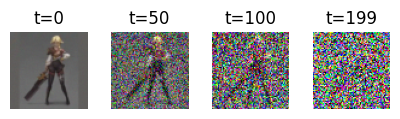

In [7]:
# Forward diffusion process

def illustrate_noising_process():
    device="cpu"
    T = 200  # Number of diffusion steps
    beta_start = 1e-4
    beta_end = 0.02
    betas = torch.linspace(beta_start, beta_end, T, device=device)
    alphas = 1. - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    def q_sample(x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha_bar = alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x_start + sqrt_one_minus_alpha_bar * noise

    # Visualize noisy images at different timesteps
    train_dataset,_ = get_datasets(experiment_name)
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    examples, _ = next(iter(train_loader))  # grab a batch
    examples = examples[:8]  # just first 8
    x = examples[:4].to(device)  # batch of clean images
    timesteps = torch.tensor([0, T//4, T//2, T-1], device=device)

    noisy_imgs = [q_sample(x, t.repeat(x.size(0)), noise=None) for t in timesteps]

    fig, axes = plt.subplots(1, 4, figsize=(5, 1))
    for i, img in enumerate(noisy_imgs):
        img_disp = img[0].detach().cpu()
        img_disp = (img_disp * 0.5 + 0.5).clamp(0, 1)   # unscale [-1,1] → [0,1]
        img_disp = img_disp.permute(1, 2, 0).numpy()   # CHW → HWC
        axes[i].imshow(img_disp)
        axes[i].set_title(f"t={timesteps[i].item()}")
        axes[i].axis('off')
    plt.show()
illustrate_noising_process()


## Checkpoint stuff

In [8]:


from elucidated_diffusion.checkpoint_helper import load_checkpoint, save_checkpoint


## 6. Elucidated Diffusion Model (EDM) Implementation

This section implements the EDM as described in the paper (2206.00364v2.pdf), including its unique noise schedule, loss weighting, and sampling procedure.

### 6a. EDM loss and schedule functions.

In [9]:
'''# EDM noise schedule, loss weighting, and sampling procedure
# EDM parameters from NVIDIA's reference
P_mean = -1.2  # Mean of log-normal distribution for sigma sampling
P_std = 1.2    # Std of log-normal distribution for sigma sampling
sigma_data = 0.5  # Data standard deviation
sigma_min = 0.002
sigma_max = 80
rho = 7

# EDM noise schedule (sampling)
def edm_sigma_schedule(t):
    return (sigma_max ** (1/rho) + t * (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho

# EDM loss weighting - CORRECTED according to NVIDIA's implementation
# weight = (σ² + σ_data²) / (σ × σ_data)²
def edm_loss_weight(sigma, sigma_data=sigma_data):
    return (sigma ** 2 + sigma_data ** 2) / (sigma * sigma_data) ** 2

if show_edm_schedule:=False:
    # Example: plot the EDM noise schedule
    ts = torch.linspace(0, 1, 100)
    sigmas = edm_sigma_schedule(ts)
    plt.plot(ts.numpy(), sigmas.numpy())
    plt.xlabel('t')
    plt.ylabel('sigma(t)')
    plt.title('EDM Noise Schedule')
    plt.show()
'''


"# EDM noise schedule, loss weighting, and sampling procedure\n# EDM parameters from NVIDIA's reference\nP_mean = -1.2  # Mean of log-normal distribution for sigma sampling\nP_std = 1.2    # Std of log-normal distribution for sigma sampling\nsigma_data = 0.5  # Data standard deviation\nsigma_min = 0.002\nsigma_max = 80\nrho = 7\n\n# EDM noise schedule (sampling)\ndef edm_sigma_schedule(t):\n    return (sigma_max ** (1/rho) + t * (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho\n\n# EDM loss weighting - CORRECTED according to NVIDIA's implementation\n# weight = (σ² + σ_data²) / (σ × σ_data)²\ndef edm_loss_weight(sigma, sigma_data=sigma_data):\n    return (sigma ** 2 + sigma_data ** 2) / (sigma * sigma_data) ** 2\n\nif show_edm_schedule:=False:\n    # Example: plot the EDM noise schedule\n    ts = torch.linspace(0, 1, 100)\n    sigmas = edm_sigma_schedule(ts)\n    plt.plot(ts.numpy(), sigmas.numpy())\n    plt.xlabel('t')\n    plt.ylabel('sigma(t)')\n    plt.title('EDM Noise Schedule

### 6b. EDM Sampling / Reconstruction

In [10]:
from elucidated_diffusion.elucidated_diffusion import edm_ancestral_sampling_for_diffusion
from elucidated_diffusion.elucidated_diffusion import edm_ancestral_sampling_for_sr
from elucidated_diffusion.elucidated_diffusion import P_mean, P_std, sigma_data, edm_loss_weight

In [11]:
'''
# EDM sampling procedure - Following NVIDIA's edm_sampler (Algorithm 2)
def edm_ancestral_sampling(model, num_steps=18, batch_size=8, img_shape=(1, 28, 28)):
    device = next(model.parameters()).device
    
    # Initialize noise
    x_next = torch.randn((batch_size,) + img_shape, device=device)
    
    # Time step schedule (matching NVIDIA's implementation)
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    t_steps = (sigma_max ** (1/rho) + step_indices / (num_steps - 1) * 
               (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])  # t_N = 0
    
    # Initialize with first noise level
    x_next = x_next * t_steps[0]
    
    # Main sampling loop (Heun's method)
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        x_cur = x_next
        
        # Preconditioning coefficients for current timestep
        sigma = t_cur.float()
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Euler step
        F_x = model(c_in * x_cur, c_noise.expand(batch_size))
        denoised = c_skip * x_cur + c_out * F_x
        d_cur = (x_cur - denoised) / t_cur
        x_next = x_cur + (t_next - t_cur) * d_cur
        
        # Apply 2nd order correction (Heun's method) - except for last step
        if i < num_steps - 1:
            # Preconditioning coefficients for next timestep
            sigma_next = t_next.float()
            c_skip_next = sigma_data ** 2 / (sigma_next ** 2 + sigma_data ** 2)
            c_out_next = sigma_next * sigma_data / (sigma_next ** 2 + sigma_data ** 2).sqrt()
            c_in_next = 1 / (sigma_data ** 2 + sigma_next ** 2).sqrt()
            c_noise_next = sigma_next.log() / 4
            
            F_x_next = model(c_in_next * x_next, c_noise_next.expand(batch_size))
            denoised_next = c_skip_next * x_next + c_out_next * F_x_next
            d_prime = (x_next - denoised_next) / t_next
            x_next = x_cur + (t_next - t_cur) * (0.5 * d_cur + 0.5 * d_prime)
    
    return x_next.to("cpu")
'''

'\n# EDM sampling procedure - Following NVIDIA\'s edm_sampler (Algorithm 2)\ndef edm_ancestral_sampling(model, num_steps=18, batch_size=8, img_shape=(1, 28, 28)):\n    device = next(model.parameters()).device\n\n    # Initialize noise\n    x_next = torch.randn((batch_size,) + img_shape, device=device)\n\n    # Time step schedule (matching NVIDIA\'s implementation)\n    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)\n    t_steps = (sigma_max ** (1/rho) + step_indices / (num_steps - 1) * \n               (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho\n    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])  # t_N = 0\n\n    # Initialize with first noise level\n    x_next = x_next * t_steps[0]\n\n    # Main sampling loop (Heun\'s method)\n    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):\n        x_cur = x_next\n\n        # Preconditioning coefficients for current timestep\n        sigma = t_cur.float()\n        c_skip = 

In [12]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def generate_images(model_edm, num_steps=15, batch_size=20, img_shape = (3,64,64)):
    to_pil = transforms.ToPILImage()
    with torch.no_grad():
        samples = edm_ancestral_sampling_for_diffusion(model_edm, num_steps=num_steps, batch_size=batch_size, img_shape=(3, 64, 64)).cpu()
        samples = (samples + 1) / 2  # scale from [-1,1] to [0,1]
        samples = samples.clamp(0, 1)
        pil_images = [to_pil(img) for img in samples]
    return pil_images

def pil_to_data_url(pil_img):
    buffered = BytesIO()
    pil_img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_str}"

def html_for_images(pil_images, min_height=64, title="Hi"):
    data_urls = [pil_to_data_url(img) for img in pil_images]
    html = f"""
    <h2>{title}</h2>
    <div style="display: flex; flex-wrap: wrap; gap: 2px;">
    """
    for url in data_urls:
        html += f"""
        <div style="flex: 0 0 auto;">
            <img src="{url}" style="min-width: {min_height}px;"/>
        </div>
        """
    html += "</div>"
    return html

def sample_html(model, batch_size=12, img_shape=(3,64,64), num_steps=36, title="EDM Samples",min_height=128):
    imgs = generate_images(model_edm=model, batch_size=batch_size, img_shape=img_shape, num_steps=16)
    h = html_for_images(imgs, title=title, min_height=min_height)
    return h


# 6c. EDM Training Loop 

In [13]:
# EDM training loop - CORRECTED with proper preconditioning coefficients
# Following NVIDIA's EDMPrecond implementation exactly

def train_a_batch(model_edm, optimizer_edm, batch):
 
        x = batch.to(device)
        
        # Log-normal sigma sampling (as in NVIDIA's implementation)
        rnd_normal = torch.randn([x.shape[0], 1, 1, 1], device=device)
        sigma = (rnd_normal * P_std + P_mean).exp()
        
        # Preconditioning coefficients (from NVIDIA's EDMPrecond)
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Add noise: y_noisy = x + σ·n where n ~ N(0,I)
        noise = torch.randn_like(x) * sigma
        y_noisy = x + noise
        
        # Model prediction: F_x = net(c_in * y_noisy, c_noise)
        c_noise_input = c_noise.view(x.shape[0])
        F_x = model_edm(c_in * y_noisy, c_noise_input)
        
        # Preconditioning: D_x = c_skip * y_noisy + c_out * F_x
        D_x = c_skip * y_noisy + c_out * F_x
        
        # Loss weight: λ(σ) = (σ² + σ_data²) / (σ·σ_data)²
        weight = edm_loss_weight(sigma.squeeze(), sigma_data).view(-1, 1, 1, 1)
        
        # Loss: weighted MSE between preconditioning output and clean image
        loss = (weight * (D_x - x) ** 2).mean()
        
        optimizer_edm.zero_grad()
        loss.backward()
        optimizer_edm.step()
        return loss.item()


In [14]:
'''

# Deprecated

import copy
import torch
import math
class EMAHelper:
    def __init__(self, model, decay=0.999):
        # Make a frozen copy of the model for EMA tracking
        self.ema_model = copy.deepcopy(model).eval()
        self.step = 0
        for p in self.ema_model.parameters():
            p.requires_grad = False

    def get_ema_decay(self,d_final=0.999, tau=2000):
        step = self.step
        # Starts near ~0.9 and approaches d_final smoothly
        return 1 - (1 - d_final) * math.exp(-step / tau)

    @torch.no_grad()
    def update(self, model):
        msd = model.state_dict()
        decay = self.get_ema_decay()
        for k, v in self.ema_model.state_dict().items():
            if k in msd:
                v.copy_(decay * v + (1 - decay) * msd[k])

    def get_model(self):
        """Return the EMA-smoothed model (already in eval mode)."""
        return self.ema_model
'''

from elucidated_diffusion.ema_helper import EMAHelper




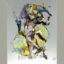
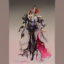
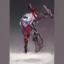
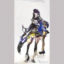
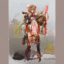
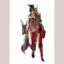
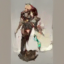
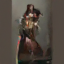
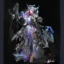
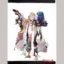
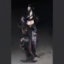
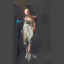

EDM Epoch 4 Loss: 0.0777:  52%|█████▏    | 53/101 [00:22<00:20,  2.39it/s]


KeyboardInterrupt: 

In [15]:

def train_some(experiment_name):
   
    model_edm = UNet128(use_attention=True).to(device)
    optimizer_edm = optim.Adam(model_edm.parameters(), lr=2e-4)
    train_dataset,_ = get_datasets(experiment_name)
    batch_size = 128
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


    if resume:=True and diffusion_weights:
        load_checkpoint(model=model_edm, optimizer=optimizer_edm, path=diffusion_weights)
    
    ema = EMAHelper(model_edm)

    t0 = time.time()
    next_display_time = t0
    display_interval = 30
    next_display_time = time.time()
    checkpoint_interval = 60 * 60
    next_checkpoint_time = time.time() + checkpoint_interval
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    path = f"outputs/{experiment_name}_{timestamp}.html"
    os.makedirs("outputs", exist_ok=True)
    with open("/tmp/training_running.txt","w"):
        pass
    for epoch in range(999999):
        pbar = tqdm(train_loader)
        if not os.path.exists("/tmp/training_running.txt"):
            break
        for x, _ in pbar:
            if not os.path.exists("/tmp/training_running.txt"):
                break
            loss = train_a_batch(model_edm,optimizer_edm,x)
            ema.update(model_edm)
            pbar.set_description(f"EDM Epoch {epoch+1} Loss: {loss:.4f}")
            if time.time() > next_checkpoint_time:
                save_checkpoint(model_edm, optimizer_edm, epoch, loss, tag=experiment_name)
                next_checkpoint_time = time.time() + checkpoint_interval
            if time.time() > next_display_time:

                next_display_time += display_interval
                dt = time.strftime('%H:%M:%S', time.gmtime(time.time() - t0))
                h = sample_html(ema.get_model(),title=f"EDM at {dt} loss {loss:.4f} ({timestamp})")
                with open(path,"a") as f:
                    f.write(h)
                ipd.clear_output(wait=True)
                ipd.display(ipd.HTML(h))
    path = save_checkpoint(model_edm, optimizer_edm, epoch, loss, tag=experiment_name)
    path = save_checkpoint(ema.get_model(), optimizer_edm, epoch, loss, tag=experiment_name+"_ema")
    del model_edm,optimizer_edm
    return path

train_some(experiment_name)
        

## Inferrence

In [ ]:
#diffusion_weights = "checkpoints/UNet128_2025-09-08_17-57-30_cats_and_dogs.pth"
#diffusion_weights = "checkpoints/UNet128_2025-09-09_06-38-40_fantasy.pth"
#load_checkpoint(model_edm, optimizer_edm, diffusion_weights)

def generate_html_examples(cp="checkpoints/UNet128_2025-09-12_19-47-15_dragon.pth",batch_size=12):
    with torch.no_grad():
        model_edm = UNet128(use_attention=True).to(device)
        optimizer_edm = None
        load_checkpoint(model_edm, optimizer_edm, cp)
        h = sample_html(model_edm,title=f"Samples from {cp}",min_height=256, batch_size=batch_size)
        ipd.display(ipd.HTML(h))
        model_edm.to('cpu')
        



🔄 Loaded checkpoint from checkpoints/UNet128_2025-09-14_02-20-07_fantasy.pth
    Epoch: 2, Loss: 0.08024808764457703
    Model class: UNet128



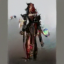
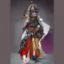
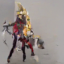
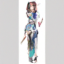
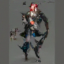
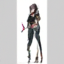

In [ ]:
generate_html_examples(cp="checkpoints/UNet128_2025-09-14_02-20-07_fantasy.pth",batch_size=6)

🔄 Loaded checkpoint from checkpoints/UNet128_2025-09-14_02-09-02_dragon.pth
    Epoch: 1, Loss: 0.1339804232120514
    Model class: UNet128



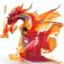
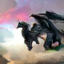
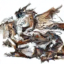
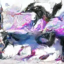
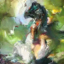
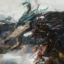

In [ ]:
generate_html_examples(cp="checkpoints/UNet128_2025-09-14_02-09-02_dragon.pth",batch_size=6)